In [2]:
%reload_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn,seaborn,tqdm -g

CPython 3.7.2
IPython 7.2.0

numpy 1.15.4
scipy 1.2.0
pandas 0.23.4
matplotlib 3.0.2
statsmodels 0.9.0
sklearn 0.20.2
seaborn 0.9.0
tqdm 4.28.1

compiler   : Clang 6.0 (clang-600.0.57)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 1ca512325465418400b2cbbb68d8fbcb6e1c8c4f


In [59]:
from __future__ import annotations

from collections import Counter, defaultdict
from csv import DictReader
from dataclasses import dataclass
from datetime import datetime
from itertools import count, product, zip_longest
from operator import attrgetter
from pathlib import Path
from typing import Iterable, Iterator, List, Tuple, TypeVar

# Disclaimer: я не фанат сокращений имен, это не дает никакой выгоды.
import numpy
import seaborn
from matplotlib import pyplot, ticker
from pandas import DataFrame
from seaborn import barplot, distplot
from tqdm import tqdm_notebook

%matplotlib inline
seaborn.set(rc={'figure.figsize': (16, 6)})

# Неделя 3. Визуальный анализ данных и построение признаков

## Часть 1. Построение признаков

Создайте на основе функций `prepare_train_set` и `prepare_sparse_train_set_window` новую – `prepare_train_set_with_fe`, (от "feature engineering"), создайте следующие признаки:

* `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
* `#unique_sites` – число уникальных сайтов в сессии
* `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
* `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый `DataFrame` (как возвращала функция `prepare_train_set`), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: `site1`, ... `site10`, `session_timespan`, `#unique_sites`, `start_hour`, `day_of_week` и `user_id` (это видно и чуть ниже по тому, как функция вызывается).

In [30]:
@dataclass
class Row:
    timestamp: datetime
    site: str
        
    def endswith(self, *suffixes: str) -> bool:
        """
        Проверяет, что адрес заканчивается на любое из окончаний.
        Пригодится в самом конце для творческих фичей.
        """
        return any(self.site.endswith(suffix) for suffix in suffixes)

        
def to_rows(reader: DictReader) -> Iterable[Row]:
    """
    Распарсить строки CSV во что-то вменяемое.
    """
    for row in reader:
        yield Row(timestamp=datetime.strptime(row['timestamp'], '%Y-%m-%d %H:%M:%S'), site=row['site'])

In [5]:
T = TypeVar('T')


def windowed(iterable: Iterable[T], *, n: int, step: int) -> Iterable[List[T]]:
    """
    Итерировать по окнам размера `n` ("размер окна") с шагом `step` ("длина сессии").
    """
    iterable = list(iterable)
    for offset in range(0, len(iterable), step):
        yield iterable[offset:offset + n]

In [6]:
def prepare_train_set_with_fe(path: Path, *, session_length: int = 10, window_size: int = 10) -> DataFrame:
    site_columns = [f'site_{i:02}' for i in range(1, window_size + 1)]
    
    # Трюк для нумерации сайтов. Каждый новый сайт получит новый ID.
    site_ids = defaultdict(count(1).__next__)

    data_frame = DataFrame(
        {
            # ID пользователя – последние четыре символа имени файла.
            'user_id': int(csv_path.stem[-4:]),
    
            # Сайты в сессии, по порядку.
            **{
                name: site_ids[entry.site] if entry else 0
                for name, entry in zip_longest(site_columns, session)
            },

            # Дополнительные фичи.
            'session_timespan': (session[-1].timestamp - session[0].timestamp).total_seconds(),
            'unique_sites': len(set(entry.site for entry in session)),
            'start_hour': session[0].timestamp.hour,
            'day_of_week': session[0].timestamp.weekday(),
        }
        for csv_path in tqdm_notebook(sorted(path.glob('*.csv')), desc='CSVs')
        for session in windowed(
            # Сразу отсортировать сессии по `timestamp`, ибо нам нужны минимумы и максимумы.
            sorted(to_rows(DictReader(csv_path.open('rt'))), key=attrgetter('timestamp')),
            n=session_length,
            step=window_size,
        )
    )
    data_frame[site_columns] = data_frame[site_columns].astype('category')
    return data_frame

Проверим функцию на игрушечном примере.

In [7]:
prepare_train_set_with_fe(Path('3users'))

,day_of_week,session_timespan,site_01,site_02,site_03,site_04,site_05,site_06,site_07,site_08,site_09,site_10,start_hour,unique_sites,user_id
0,4,7998.0,1,2,2,3,2,4,5,6,7,8,9,8,1
1,4,60.0,1,4,4,4,0,0,0,0,0,0,12,2,1
2,4,7935.0,1,2,9,9,2,0,0,0,0,0,9,3,2
3,4,7998.0,10,4,2,4,2,4,4,6,11,10,9,5,3
4,4,1471.0,10,4,2,0,0,0,0,0,0,0,12,3,3


Примените функцию `prepare_train_set_with_fe` к данным по 10 пользователям, укажите `session_length=10`.

In [8]:
frame_10_users = prepare_train_set_with_fe(Path('10users'))

Примените функцию `prepare_train_set_with_fe` к данным по 150 пользователям, укажите `session_length=10`.

In [9]:
frame_150_users = prepare_train_set_with_fe(Path('150users'))

**Вопрос 1. Выведите медианную продолжительность сессии (`session_timespan`) для сессий 10 пользователей.**

In [10]:
frame_10_users['session_timespan'].median()

37.0

**Вопрос 2. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [11]:
frame_10_users['day_of_week'].median()

2.0

**Вопрос 3. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [12]:
frame_150_users['start_hour'].median()

13.0

**Вопрос 4. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [13]:
frame_150_users['unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.

In [14]:
frame_10_users['user_id'] = frame_10_users['user_id'].map({
    128: 'Mary-Kate',
    39: 'Ashley',
    207: 'Lindsey',
    127: 'Naomi',
    237: 'Avril',
    33: 'Bob',
    50: 'Bill',
    31: 'John',
    100: 'Dick',
    241: 'Ed',
})
frame_10_users.head()

,day_of_week,session_timespan,site_01,site_02,site_03,site_04,site_05,site_06,site_07,site_08,site_09,site_10,start_hour,unique_sites,user_id
0,4,33.0,1,2,3,4,3,3,4,3,5,3,8,5,John
1,4,284.0,6,7,8,9,3,10,11,12,13,14,8,10,John
2,4,258.0,14,4,14,14,15,16,6,17,18,14,8,7,John
3,4,30.0,19,20,19,14,14,14,14,21,22,23,8,6,John
4,4,6.0,24,14,15,25,26,27,28,29,30,29,8,9,John


**1. Постройте гистограмму распределения длины сессии в секундах (`session_timespan`). Ограничьте по `x` значением `200` (иначе слишком тяжелый хвост). Сделайте гистограмму цвета `darkviolet`, подпишите оси по-русски.**

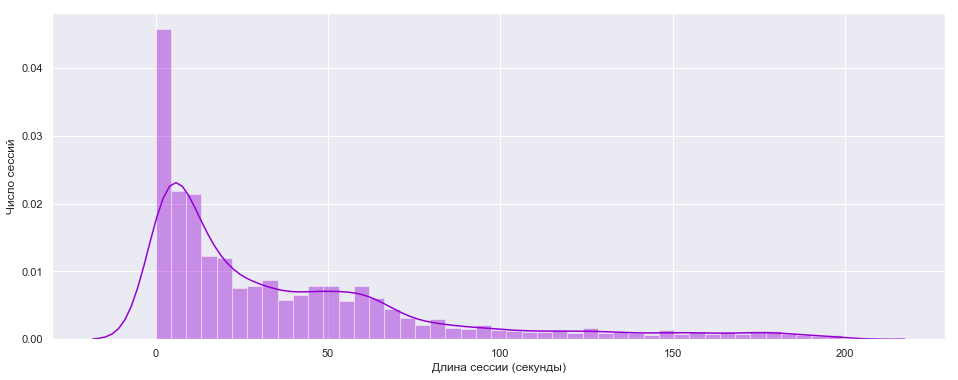

In [15]:
distplot(
    frame_10_users[frame_10_users['session_timespan'] < 200]['session_timespan'],
    color='darkviolet',
).set(xlabel='Длина сессии (секунды)', ylabel='Число сессий');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (`#unique_sites`). Сделайте гистограмму цвета `aqua`, подпишите оси по-русски.**

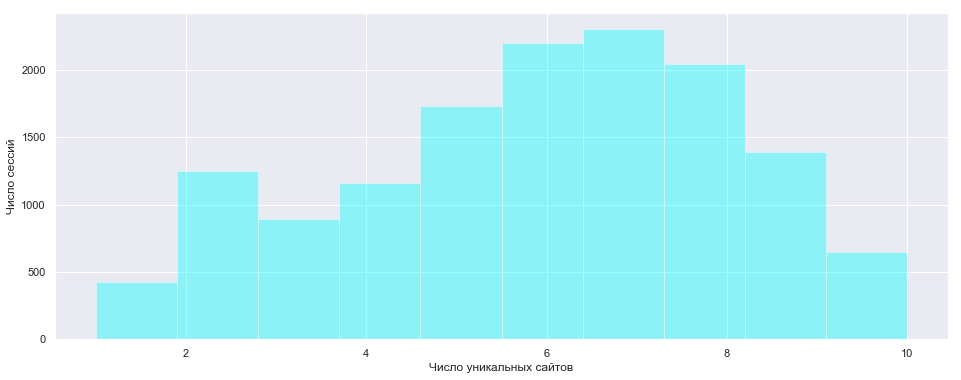

In [16]:
distplot(frame_10_users['unique_sites'], color='aqua', kde=False, bins=10) \
    .set(xlabel='Число уникальных сайтов', ylabel='Число сессий');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (`#unique_sites`) для каждого из 10 пользователей по отдельности. Используйте `subplots`, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (`color_dic`). Подпишите оси по-русски в каждой из 10 гистограмм.**

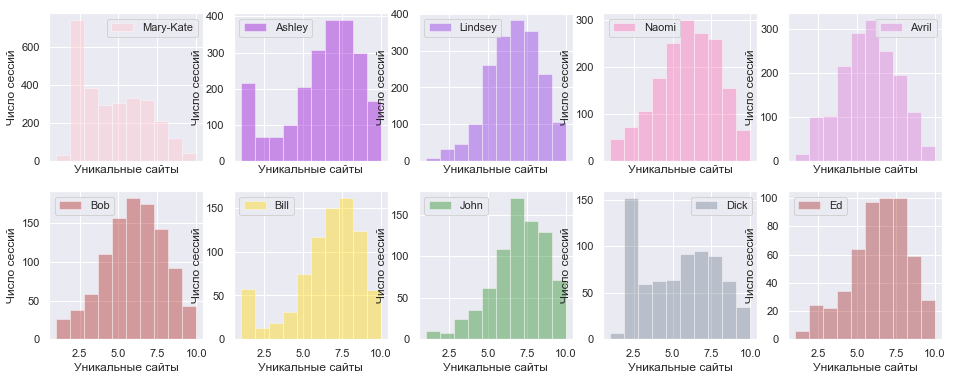

In [17]:
colors = [
    ('Mary-Kate', 'pink'),
    ('Ashley', 'darkviolet'),
    ('Lindsey','blueviolet'),
    ('Naomi', 'hotpink'),
    ('Avril', 'orchid'),
    ('Bob', 'firebrick'),
    ('Bill', 'gold'),
    ('John', 'forestgreen'),
    ('Dick', 'slategrey'),
    ('Ed', 'brown'),
]

_, axes = pyplot.subplots(2, 5, sharex=True)

for (i, j), (name, color) in zip(product(range(2), range(5)), colors):
    x = frame_10_users[frame_10_users['user_id'] == name]['unique_sites']
    plot = distplot(x, kde=False, color=color, ax=axes[i, j], bins=10, label=name)
    plot.set(xlabel='Уникальные сайты', ylabel='Число сессий')
    plot.legend()

**4. Постройте гистограмму распределения часа начала сессии (`start_hour`). Сделайте гистограмму цвета `darkgreen`, подпишите оси по-русски.**

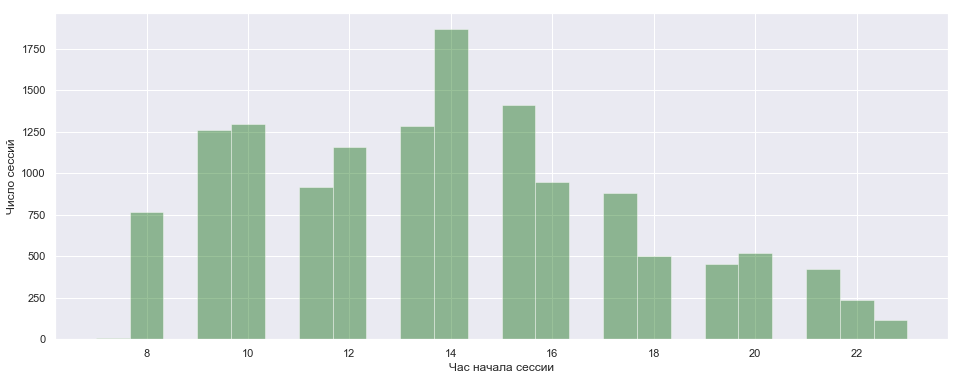

In [18]:
distplot(frame_10_users['start_hour'], color='darkgreen', kde=False, bins=24) \
    .set(xlabel='Час начала сессии', ylabel='Число сессий');

**5. Постройте гистограммы распределения часа начала сессии (`start_hour`) для каждого из 10 пользователей по отдельности. Используйте `subplots`, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (`color_dic`). Подпишите оси по-русски в каждой из 10 гистограмм.**

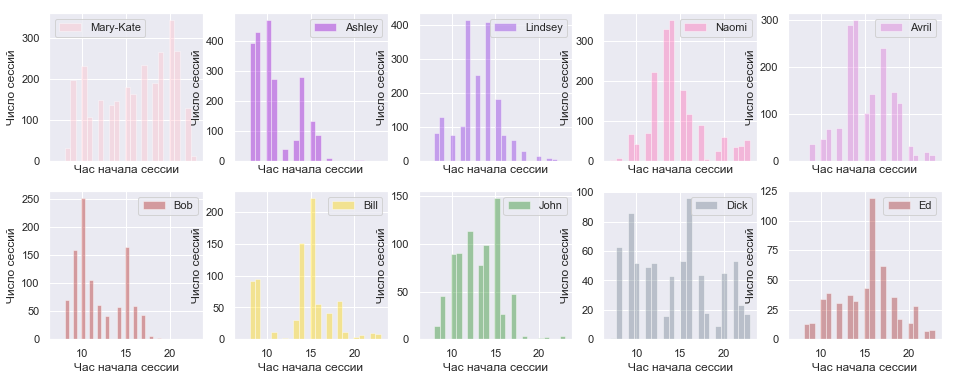

In [19]:
_, axes = pyplot.subplots(2, 5, sharex=True)

for (i, j), (name, color) in zip(product(range(2), range(5)), colors):
    x = frame_10_users[frame_10_users['user_id'] == name]['start_hour']
    plot = distplot(x, kde=False, color=color, ax=axes[i, j], bins=24, label=name)
    plot.set(xlabel='Час начала сессии', ylabel='Число сессий')
    plot.legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (`day_of_week`). Сделайте гистограмму цвета `sienna`, подпишите оси по-русски.**

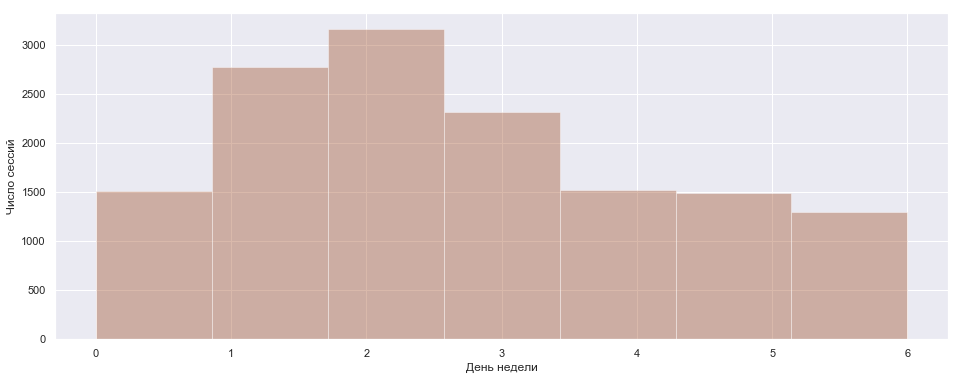

In [20]:
distplot(frame_10_users['day_of_week'], color='sienna', kde=False, bins=7) \
    .set(xlabel='День недели', ylabel='Число сессий');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (`day_of_week`) для каждого из 10 пользователей по отдельности. Используйте `subplots`, чтоб разместить все 10 картинок на одной большой. Измените метки по оси X на `['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']` – метод `set_xticklabels`. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (`color_dic`). Подпишите по-русски название каждой из 10 гистограмм.**

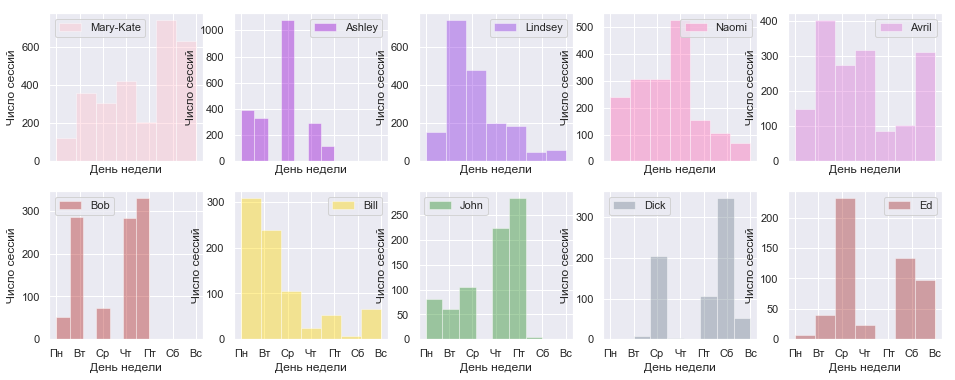

In [21]:
_, axes = pyplot.subplots(2, 5, sharex=True)

for (i, j), (name, color) in zip(product(range(2), range(5)), colors):
    x = frame_10_users[frame_10_users['user_id'] == name]['day_of_week']
    plot = distplot(x, kde=False, color=color, ax=axes[i, j], bins=7, label=name)
    axes[i, j].set_xticklabels([None, 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    plot.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    plot.set(xlabel='День недели', ylabel='Число сессий')
    plot.legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**Mary-Kate**

Заходит посмотреть только парочку сайтов, но зато круглосуточно и регулярно. Особенно любит интернетики в выходные.

**Ashley**

Не сидит по вечерам и выходным в интернетиках, зато в остальное время отрывается по полной и читает все на свете.

**Lindsey**

Тоже любит ходить в интернетики днем и по будням, но не брезгует выходными, а если заходит – то выйти уже не может. Коротких сессий мало.

**Naomi**

Похожа на Lindsey, но еще и полуночница.

**Avril**

Похож на двух предыдущих, но пятница и суббота – святое, залипать в интернетах в эти дни – грех. Полуночница, хотя в основном сидит днем.

**Bob**

Похоже, любит позалипать за завтраком и обедом.

**Bill**

Этот к концу недели устает от всех этих ваших мемчиков.

**John**

Конкретно залипает по будням в рабочее время. Хе-хе-хе.

**Dick**

Только начинаются выходные и все, он уже круглосуточно в сети, помалу и регулярно. Он чередует сон с парочкой сайтов что ли?

**Ed**

Любит позалипать в середине дня и надолго.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

Честно говоря, я их уже посеял. Давайте пересчитаем.

In [22]:
def obtain_site_frequencies(path: Path) -> Counter:
    return Counter(
        row.site
        for csv_path in tqdm_notebook(list(path.glob('*.csv')), desc='CSVs')
        for row in to_rows(DictReader(csv_path.open('rt')))
    )

    
site_counter = obtain_site_frequencies(Path('10users'))

Определите топ-10 самых посещаемых сайтов (`top10_sites`) и соответствующие кол-ва посещений (`top10_freqs`).

In [23]:
DataFrame(site_counter.most_common(10), columns=['site', 'count']).set_index('site')

,count
site,
s.youtube.com,8300
www.google.fr,7813
www.google.com,5441
mail.google.com,4158
www.facebook.com,4141
apis.google.com,3758
r3---sn-gxo5uxg-jqbe.googlevideo.com,3244
r1---sn-gxo5uxg-jqbe.googlevideo.com,3094
plus.google.com,2630


**9. Нарисуйте `seaborn` `barplot`, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (`xticks`).**

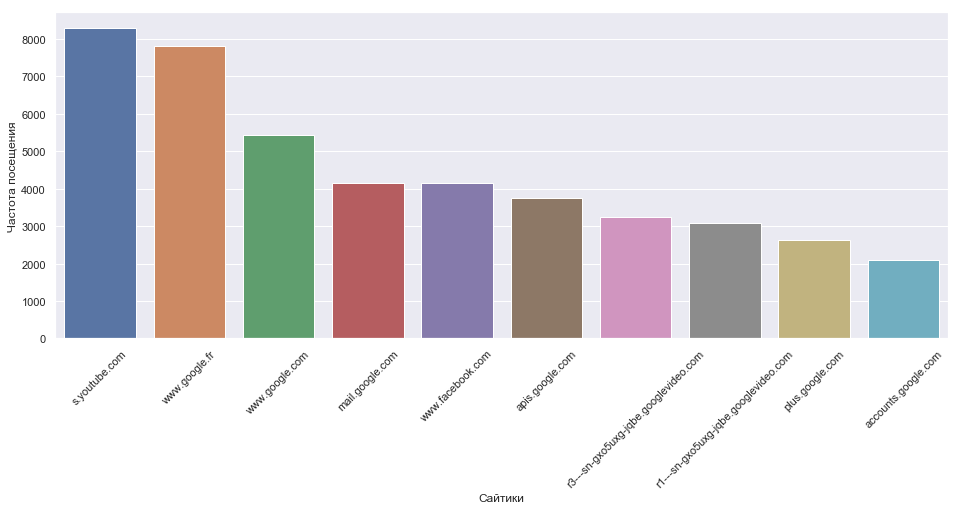

In [24]:
x, y = zip(*site_counter.most_common(10))  # `zip(('s.youtube.com', 8300), ('www.google.fr', 7813), ...)`
plot = barplot(x=list(x), y=list(y))
pyplot.xticks(rotation=45)
plot.set(xlabel='Сайтики', ylabel='Частота посещения');

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки.

На следующей неделе мы будем использовать "мешок" сайтов для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):

- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами `session_length=10` и `window_size=10`. Сериализуйте полученные матрицы с помощью `pickle`. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

А давайте я просто скопирую свою прекрасную функцию и добавлю новые признаки туда. У меня уже и без того `pickle`-ад в папке с курсом.

In [35]:
def count_hits(session: Iterable[Row], *suffixes: str) -> int:
    return sum(entry.endswith(*suffixes) for entry in session)


def prepare_train_set_with_fe(path: Path, *, session_length: int = 10, window_size: int = 10) -> DataFrame:
    site_columns = [f'site_{i:02}' for i in range(1, window_size + 1)]
    
    # Трюк для нумерации сайтов. Каждый новый сайт получит новый ID.
    site_ids = defaultdict(count(1).__next__)

    data_frame = DataFrame(
        {
            # ID пользователя – последние четыре символа имени файла.
            'user_id': int(csv_path.stem[-4:]),
    
            # Сайты в сессии, по порядку.
            **{
                name: site_ids[entry.site] if entry else 0
                for name, entry in zip_longest(site_columns, session)
            },

            # Дополнительные фичи.
            'session_timespan': (session[-1].timestamp - session[0].timestamp).total_seconds(),
            'unique_sites': len(set(entry.site for entry in session)),
            'start_hour': session[0].timestamp.hour,
            'day_of_week': session[0].timestamp.weekday(),
            
            # Творческие фичи. Ну, с творчеством у меня всегда было не очень.
            # Давайте попробуем выделить определенные сценарии использования интернетиков.
            'social_media_hits': count_hits(session, 'facebook.com', 'twitter.com', 'plus.google.com', 'tumblr.com'),
            'software_development_hits': count_hits(session, 'javafx.com', 'msdn.microsoft.com', 'platform.twitter.com', 'stackoverflow.com', 'xpathtester.com'),
            'wikimedia_hits': count_hits(session, 'wikimedia.org'),
            'search_hits': count_hits(session, 'google.com', 'google.fr', 'bing.com'),
            'mail_hits': count_hits(session, 'mail.live.com', 'webmail.laposte.net', 'mail.google.com'),
            'entertainment_hits': count_hits(session, 'youtube.com', 'googlevideo.com'),
            'office_hits': count_hits(session, 'docs.google.com', 'drive.google.com'),
            'shopping_hits': count_hits(session, 'ebay.fr'),
        }
        for csv_path in tqdm_notebook(sorted(path.glob('*.csv')), desc=f'CSVs {path}')
        for session in windowed(
            # Сразу отсортировать сессии по `timestamp`, ибо нам нужны минимумы и максимумы.
            sorted(to_rows(DictReader(csv_path.open('rt'))), key=attrgetter('timestamp')),
            n=session_length,
            step=window_size,
        )
    )
    data_frame[site_columns] = data_frame[site_columns].astype('category')
    return data_frame

In [36]:
frame_10_users = prepare_train_set_with_fe(Path('10users'))
frame_10_users.head()

,day_of_week,entertainment_hits,mail_hits,office_hits,search_hits,session_timespan,shopping_hits,site_01,site_02,site_03,...,site_07,site_08,site_09,site_10,social_media_hits,software_development_hits,start_hour,unique_sites,user_id,wikimedia_hits
0,4,0,0,0,2,33.0,0,1,2,3,...,4,3,5,3,0,0,8,5,31,0
1,4,0,1,0,0,284.0,0,6,7,8,...,11,12,13,14,0,1,8,10,31,0
2,4,0,4,0,1,258.0,0,14,4,14,...,6,17,18,14,1,0,8,7,31,0
3,4,0,4,0,0,30.0,0,19,20,19,...,14,21,22,23,0,0,8,6,31,0
4,4,0,1,0,0,6.0,0,24,14,15,...,28,29,30,29,1,0,8,9,31,0


In [41]:
frame_150_users = prepare_train_set_with_fe(Path('150users'))
frame_150_users.head()

,day_of_week,entertainment_hits,mail_hits,office_hits,search_hits,session_timespan,shopping_hits,site_01,site_02,site_03,...,site_07,site_08,site_09,site_10,social_media_hits,software_development_hits,start_hour,unique_sites,user_id,wikimedia_hits
0,4,0,0,0,8,57.0,0,1,1,2,...,1,3,4,5,0,0,8,5,6,0
1,4,0,0,0,1,1618.0,0,3,6,7,...,8,9,10,10,0,0,8,8,6,0
2,4,0,0,0,6,2010.0,0,5,11,1,...,9,5,3,1,0,0,8,5,6,0
3,4,0,0,0,5,2006.0,0,1,1,12,...,12,1,14,1,0,0,9,4,6,0
4,4,0,0,0,10,10.0,0,1,1,15,...,16,17,18,15,0,0,9,5,6,0


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Гистограммы! Я сегодня сделал их много! Нужно больше!

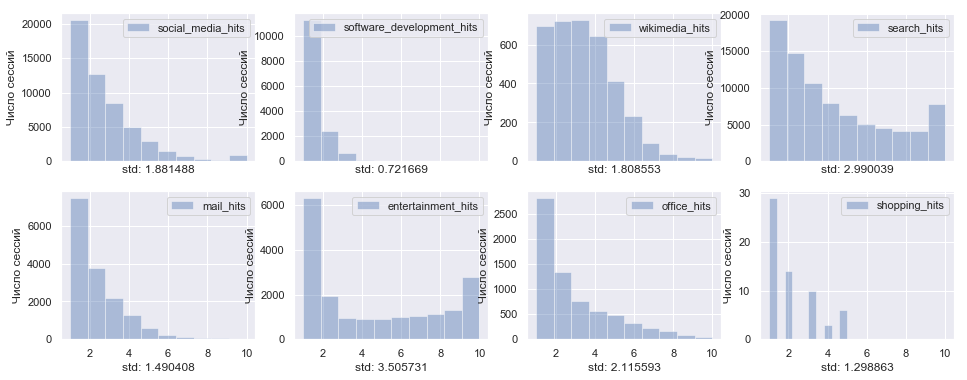

In [72]:
_, axes = pyplot.subplots(2, 4, sharex=True)
features = [
    'social_media_hits',
    'software_development_hits',
    'wikimedia_hits',
    'search_hits',
    'mail_hits',
    'entertainment_hits',
    'office_hits',
    'shopping_hits',
]

for (i, j), feature in zip(product(range(2), range(4)), features):
    x = frame_150_users[feature]
    x = x[x != 0]  # нули здорово мешают на графиках, их слишком много
    plot = distplot(x, kde=False, ax=axes[i, j], bins=10, label=feature)
    plot.set(xlabel=f'std: {numpy.std(x):2f}', ylabel='Число сессий')
    plot.legend()

Так, теперь прокомментировать.

Мне нравятся `social_media_hits`, `wikimedia.hits`, `search_hits`, `mail_hits`, `entertainment_hits` и `office_hits`. Они принимают (почти) полный диапазон значений, а большая дисперсия это хорошо.

`software_development_hits` казался неплохим признаком, чтобы распознать определенную категорию пользователей, но по факту не принимает не очень много значений. На него сложно будет настроиться.

`shopping_hits` возможно тоже неплох.

**В конце сохраните в `pickle`-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (`session_timespan`, `#unique_sites`, `start_hour`, `day_of_week`), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров `session_length` и `window_size`.**

Нет, давайте я не буду этого делать. У меня этих файлов там несколько десятков, я уже не помню что к чему. Давайте вы мне просто поверите, что я это умею, а в следующий раз я просто перестрою признаки. Это занимает меньше минуты.

## Критерии оценки работы (только для Peer Review в специализации):

- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)